#  __Classification Model comparison and selection__

### Requirements for the notebook

!pip install pandas seaborn numpy scikit-learn xgboost lightgbm rdkit useful_rdkit_utils scipy mlxtend scikit_posthocs 

__Install lighgbm with mamba or conda if there are issues__

!mamba install lightgbm

In [1]:
# Obtaining the python scripts for delong_ci and bootstrap from Pat Walters github repo

# Definition function to download the files
def download_text_file(url):
    res = requests.get(url)
    fileneame = os.path.basename(url)
    if not os.path.exists(fileneame):
        with open(fileneame, 'w') as ifs:
            ifs.write(res.text)
    else:
        print(f"File {fileneame} already exists")

import os
import requests

# Downloading the file from github
support_url_list = [
    "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/support_libs/bootstrap.py",
    "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/support_libs/delong_ci.py"
]
for url in support_url_list:
    download_text_file(url)


File bootstrap.py already exists
File delong_ci.py already exists


In [21]:
import pandas as pd
import numpy as np  
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from rdkit import Chem
from mlxtend.evaluate import cochrans_q, mcnemar, mcnemar_table
from mlxtend.evaluate import paired_ttest_5x2cv
from tqdm.auto import tqdm
from tqdm.notebook import tqdm
from itertools import combinations
from scipy.stats import wilcoxon
from scipy import stats
import scikit_posthocs as sp
import useful_rdkit_utils as uru

# This is a script that is on Pat Walters GIthub repo called comparing classifiers
from delong_ci import calc_auc_ci # Need to change np.float to float in script
from bootstrap import bootstrap_error_estimate

# Setting up optional defaults for seaborn and pandas
sns.set_theme(rc={'figure.figsize':(7, 7)})
sns.set_theme(font_scale=1.5)
sns.set_style("white")

pd.set_option('display.precision', 2) # Number of decimal places shown in pd Dataframe
tqdm.pandas()



In [3]:
# Reading in data
df = pd.read_csv("HDAC1_ChEMBL_prepared_data/HDAC1_ChEMBL_IC50.csv")
df.head()

,Unnamed: 0,molecule_chembl_id,IC50,units,SMILES,pIC50,activity_label,ML_activity_label
0,0,CHEMBL3621294,6.87e-03,nM,O=C(CCCCCCC(=O)Nc1ccc2c(c1)/C(=C/c1ccc[nH]1)C(...,11.16,active,1
1,1,CHEMBL3689858,1.00e-02,nM,CCC(CC)CN(CC)Cc1c(C)nc2cc(/C=C/C(=O)NO)ccn12,11.00,active,1
2,2,CHEMBL3689829,2.00e-02,nM,CCCCNCc1c(CCCC)nc2cc(/C=C/C(=O)NO)ccn12,10.70,active,1
3,3,CHEMBL4861467,5.00e-02,nM,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(CC1CC1)C...,10.30,active,1
4,4,CHEMBL3689834,6.00e-02,nM,CCCCc1nc2cc(/C=C/C(=O)NO)ccn2c1CN(CC)CCCC,10.22,active,1


/Users/luke_zondagh_m1/Softwares/miniforge3/envs/PatWalters_tutorial/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/luke_zondagh_m1/Softwares/miniforge3/envs/PatWalters_tutorial/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


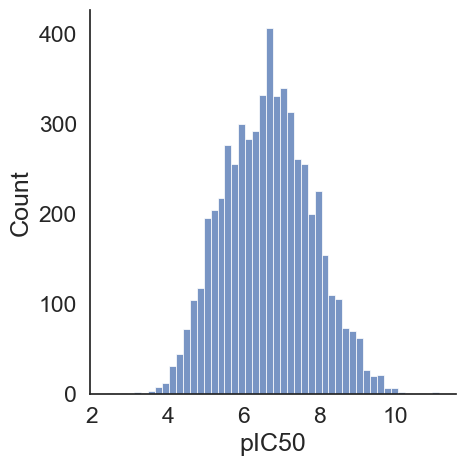

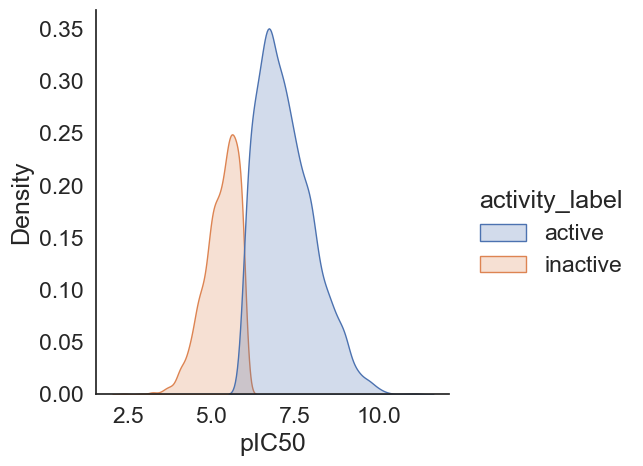

In [4]:
sns.displot(df.pIC50)
sns.displot(df, x="pIC50", hue="activity_label", kind="kde", fill=True)

In [5]:
# Labeling data as active or inactive with respect to pIC50 as 1 or 0
# This was condcuted n the 9_TOCASS_Data_Acquisition.ipynb notebook for HDAC

# Code to label the data as active or inactive
#df["ML_activity_label"] = [int(x >=6) for x in df["pIC50"]]

In [6]:
# Adding rdkit molecule and fingerprints to the dataframe

# Generate rdkit_mol
df["rdkit_mol"] = df.SMILES.progress_apply(Chem.MolFromSmiles)

# Generate fp using Morgan Fingerprints
df["fp"] = df.rdkit_mol.progress_apply(uru.mol2morgan_fp)

df.head()

  0%|          | 0/5752 [00:00<?, ?it/s]

  0%|          | 0/5752 [00:00<?, ?it/s]

,Unnamed: 0,molecule_chembl_id,IC50,units,SMILES,pIC50,activity_label,ML_activity_label,rdkit_mol,fp
0,0,CHEMBL3621294,6.87e-03,nM,O=C(CCCCCCC(=O)Nc1ccc2c(c1)/C(=C/c1ccc[nH]1)C(...,11.16,active,1,<rdkit.Chem.rdchem.Mol object at 0x151771e00>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,CHEMBL3689858,1.00e-02,nM,CCC(CC)CN(CC)Cc1c(C)nc2cc(/C=C/C(=O)NO)ccn12,11.00,active,1,<rdkit.Chem.rdchem.Mol object at 0x151771e70>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,CHEMBL3689829,2.00e-02,nM,CCCCNCc1c(CCCC)nc2cc(/C=C/C(=O)NO)ccn12,10.70,active,1,<rdkit.Chem.rdchem.Mol object at 0x151771d90>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,CHEMBL4861467,5.00e-02,nM,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(CC1CC1)C...,10.30,active,1,<rdkit.Chem.rdchem.Mol object at 0x151771d20>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,CHEMBL3689834,6.00e-02,nM,CCCCc1nc2cc(/C=C/C(=O)NO)ccn2c1CN(CC)CCCC,10.22,active,1,<rdkit.Chem.rdchem.Mol object at 0x151771cb0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### __Assessing multiple classification models using cross-validation__

**Models to be evaluated:**
1. Extreme Gradient Boosting (XGBoost) classifier

2. Random Forest classifier

3. Light Gradient Boosting Machine (LightGBM)


In [8]:
classifier_list = [XGBClassifier, 
                   LGBMClassifier, 
                   RandomForestClassifier, 
                   ]

#Extract the names of the classifiers
classifier_names_list = [x().__class__.__name__ for x in classifier_list]
# Remove Classifier from the names
classifier_names_list = [x.replace('Classifier', '') for x in classifier_names_list]

# Setting empty lists and hyperpramaters
truth_list = []
pred_list = []
prob_list = []
cv_cycles = 10 # Number of cross validation cycles

# Looping through the classifiers using cross-calidation for each
for i in tqdm(range(0, cv_cycles)):
    train, test = train_test_split(df, test_size=0.2, random_state=42)

    # Setting trainin and test sets
    X_train = np.stack(train["fp"])
    X_test = np.stack(test["fp"])
    y_train = train["ML_activity_label"].values
    y_test = test["ML_activity_label"].values

    # Storing the predicted and probability values for each cycle
    cycle_predicted = []
    cycle_probability = []

    # training the classifiers and predicting the results
    for method in classifier_list:
        classifier = method(n_jobs=-1) # Run on all available processes
        # Train the classifier
        classifier.fit(X_train, y_train)

        # Predict the results and append to the list
        cycle_predicted.append(classifier.predict(X_test))
        cycle_probability.append(classifier.predict_proba(X_test))

    # Storing the experimenatal, probability and predicted values
    truth_list.append(test.ML_activity_label.values)
    pred_list.append(cycle_predicted)
    prob_list.append(cycle_probability)



  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 3199, number of negative: 1402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2674
[LightGBM] [Info] Number of data points in the train set: 4601, number of used features: 1337
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.695284 -> initscore=0.824938
[LightGBM] [Info] Start training from score 0.824938
[LightGBM] [Info] Number of positive: 3199, number of negative: 1402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2674
[LightGBM] [Info] Number of data points in the train set: 4601, number of used features: 1337
[LightGBM] [Info] [bin

### Alternative way of splitting data

In [ ]:
classifier_list = [XGBClassifier, 
                   LGBMClassifier, 
                   RandomForestClassifier, 
                   ]

#Extract the names of the classifiers
classifier_names_list = [x().__class__.__name__ for x in classifier_list]
# Remove Classifier from the names
classifier_names_list = [x.replace('Classifier', '') for x in classifier_names_list]

# Setting empty lists and hyperpramaters
t_truth_list = []
t_pred_list = []
t_prob_list = []
cv_cycles = 10 # Number of cross validation cycles

# Looping through the classifiers using cross-calidation for each
for i in tqdm(range(0, cv_cycles)):
    # Setting trainin and test sets
    X = np.stack(df["fp"])
    y = df["ML_activity_label"].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Storing the predicted and probability values for each cycle
    t_cycle_predicted = []
    t_cycle_probability = []

    # training the classifiers and predicting the results
    for method in classifier_list:
        classifier = method(n_jobs=-1) # Run on all available processes
        # Train the classifier
        classifier.fit(X_train, y_train)

        # Predict the results and append to the list
        t_cycle_predicted.append(classifier.predict(X_test))
        t_cycle_probability.append(classifier.predict_proba(X_test))

    # Storing the experimenatal, probability and predicted values
    t_truth_list.append(test.ML_activity_label.values)
    t_pred_list.append(t_cycle_predicted)
    t_prob_list.append(t_cycle_probability)

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 3199, number of negative: 1402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2674
[LightGBM] [Info] Number of data points in the train set: 4601, number of used features: 1337
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.695284 -> initscore=0.824938
[LightGBM] [Info] Start training from score 0.824938
[LightGBM] [Info] Number of positive: 3199, number of negative: 1402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2674
[LightGBM] [Info] Number of data points in the train set: 4601, number of used features: 1337
[LightGBM] [Info] [bin

In [33]:
# Evaluate the models using the AUC and ROC curve
auc_results = []
for truth, prob in zip(truth_list, prob_list):
    for name, p in zip(classifier_names_list, prob):
        auc_results.append([name, roc_auc_score(truth, p[:, 1])])

auc_df = pd.DataFrame(auc_results, columns=["Classifier", "AUC"])
auc_df.head()


,Classifier,AUC
0,XGB,0.92
1,LGBM,0.91
2,RandomForest,0.91
3,XGB,0.92
4,LGBM,0.91


### __Pat Walters notes__

**DO NOT** use a bar plot with a error bar to show Standard Deviation

A better yet still less than correct way is to use a boxplots

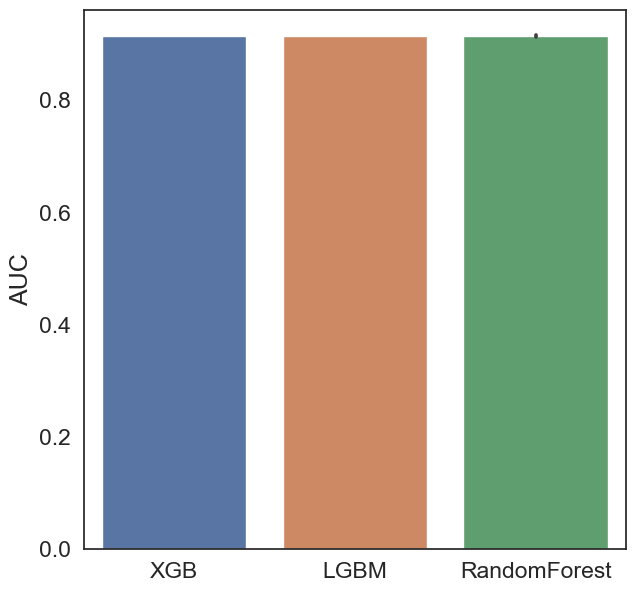

In [10]:
# Bar plot
ax = sns.barplot(x="Classifier",y="AUC",data=auc_df)
labels = [x.get_text() for x in ax.get_xticklabels()]
ax.set(xticklabels=labels)
_ = ax.set(xlabel="")

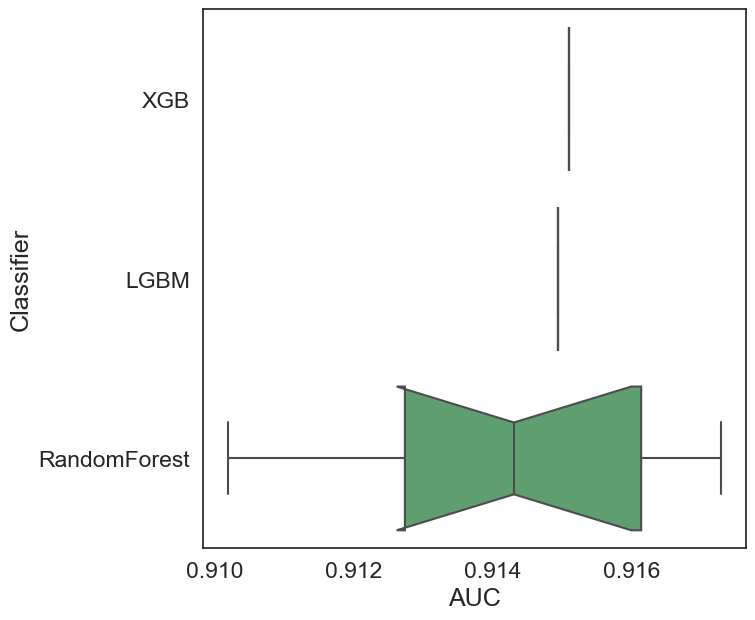

In [11]:
# Box plot
ax = sns.boxplot(y="Classifier",x="AUC",data=auc_df,notch=True)

### Rather conduct the following

1. Confidence intervals for AUC using DeLong method

2. Bootstrap the Error Estimate

In [12]:
# Delong confidence interval for AUC
auc_results = []
for cycle, [truth, prob] in enumerate(zip(truth_list, prob_list)):
    for name, p in zip(classifier_names_list, prob):
        truth = np.array([int(x) for x in truth])
        auc, (lb, ub) = calc_auc_ci(truth, p[:, 1])
        auc_results.append([cycle, name, auc, lb, ub])

auc_ci_df = pd.DataFrame(auc_results, columns=["Cycle", "Classifier", "AUC", "LB", "UB"])
auc_ci_df.head()


,Cycle,Classifier,AUC,LB,UB
0,0,XGB,0.92,0.90,0.93
1,0,LGBM,0.91,0.90,0.93
2,0,RandomForest,0.91,0.89,0.93
3,1,XGB,0.92,0.90,0.93
4,1,LGBM,0.91,0.90,0.93


### Designing a function to plot the confidence intervals

In [39]:
def ci_pointplot(input_df, x_col="Cycle", y_col="AUC", hue_col="Method", lb_col="LB", ub_col="UB"):
    dodge_val = 0.25
    palette_name = 'deep'
    cv_cycles = len(input_df[x_col].unique())
    ax = sns.pointplot(x=x_col, y=y_col, hue=hue_col, data=input_df, dodge=dodge_val, join=False, palette=palette_name)
    ax.axvline(0.5, ls="--", c="gray")
    for x in np.arange(0.5, cv_cycles, 1):
        ax.axvline(x, ls="--", c="gray")
    y_val = input_df[y_col]
    lb = y_val - input_df[lb_col]
    ub = input_df[ub_col] - y_val
    x_pos = []
    cols = sns.color_palette(palette_name)[:3]
    for i in range(0, cv_cycles):
        x_pos += [i - dodge_val / 2, i, i + dodge_val / 2]
    _ = ax.errorbar(x_pos, y_val, yerr=[lb, ub], fmt="none", capsize=0,ecolor=cols)

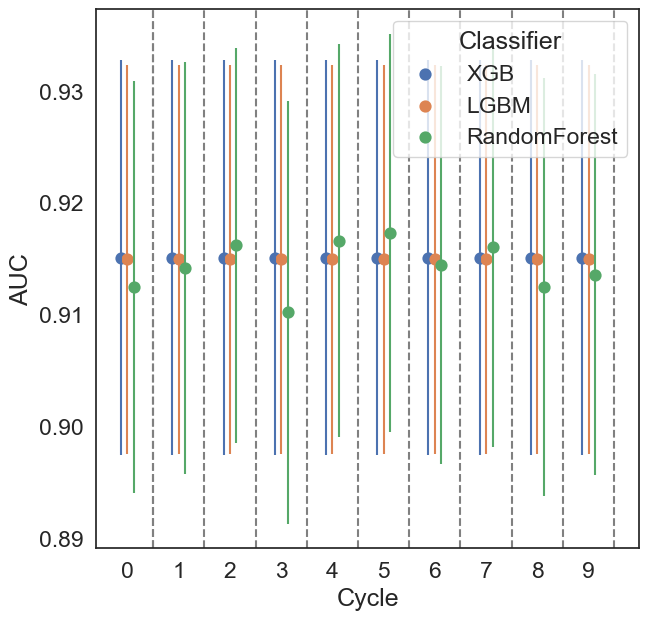

In [40]:
ci_pointplot(auc_ci_df, x_col="Cycle", y_col="AUC", hue_col="Classifier", lb_col="LB", ub_col="UB")

In [38]:
# Boostrap an Error Estimate
bootstrap_results = []
with tqdm(total=len(truth_list)) as pbar:
    for cycle, [truth, prob] in enumerate(zip(truth_list, prob_list)):
        for name, p in zip(classifier_names_list, prob):
            auc = roc_auc_score(truth, p[:, 1])
            lb, ub = bootstrap_error_estimate(truth, p[:, 1], roc_auc_score)
            bootstrap_results.append([cycle, name, auc, lb, ub])
        pbar.update(1)

bootstrap_df = pd.DataFrame(bootstrap_results, columns=["Cycle", "Classifier", "AUC", "LB", "UB"])



  0%|          | 0/10 [00:00<?, ?it/s]

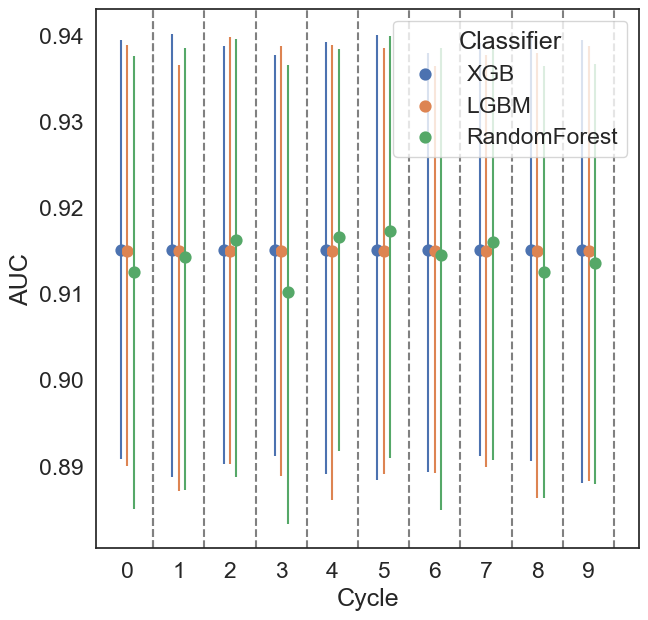

In [41]:
# Plot the bootstrap results
ci_pointplot(bootstrap_df, x_col="Cycle", y_col="AUC", hue_col="Classifier", lb_col="LB", ub_col="UB")

## Running the models using a 5 by 2-fold cross validation

This allows one to compare models using 50% train test split for 2 models through 5 iterations of splitting.

Then the accuracy score of each iteration is calculated and processed to obtain the p-value using t-statics analysis

null hypothesis is that teh models perform the same. > 0.05 shows that the models do not perform the same

for more information: https://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_5x2cv/

In [50]:
X = np.stack(df["fp"])
y = df.ML_activity_label.values
# Defining the classifiers to run with 5x2 cross validation
classifier_CV_list = [x(n_jobs=-1) for x in classifier_list]
# printing heading for the table to let the user know which classifier is method 1 or 2
print(f"{'Method_1':12s} {'Method_2':12s} {'p-vlaue'}")

results = []
# Running paired t-test 5x2 cross validation
for a,b in combinations(zip(classifier_CV_list, classifier_names_list), 2):
    classifier_1, name_1 = a
    classifier_2, name_2 = b
    # Running the paired t-test. t is the t-statistic and p is the p-value
    t, p = paired_ttest_5x2cv(estimator1=classifier_1, 
                              estimator2=classifier_2, 
                              X=X, 
                              y=y, 
                              scoring="roc_auc")

    results = results + [[name_1, name_2, p]]

results = pd.DataFrame(results, columns=["Method_1", "Method_2", "p-value"])
results

Method_1     Method_2     p-vlaue
[LightGBM] [Info] Number of positive: 1988, number of negative: 888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 2876, number of used features: 1049
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.691238 -> initscore=0.805913
[LightGBM] [Info] Start training from score 0.805913
[LightGBM] [Info] Number of positive: 2021, number of negative: 855
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2078
[LightGBM] [Info] Number of data points in the train set: 2876, number of used featu

,Method_1,Method_2,p-value
0,XGB,LGBM,0.08
1,XGB,RandomForest,0.51
2,LGBM,RandomForest,0.70


## McNerman's Test form mlxtend

null hypothesis is that teh models perform the same. > 0.05 shows that the models do not perform the same

For more details: https://rasbt.github.io/mlxtend/user_guide/evaluate/mcnemar/

In [51]:
mcnemar_results = []
for truth, pred in zip(truth_list, pred_list):
    for i,j in combinations(range(len(classifier_names_list)), 2):
        mc, mc_pvalue = mcnemar(mcnemar_table(truth, pred[i], pred[j]))
        mcnemar_results.append([classifier_names_list[i], classifier_names_list[j], mc, mc_pvalue])

mcnemar_df = pd.DataFrame(mcnemar_results, columns=["Classifier_1", "Classifier_2", "McNemar", "p-value"])
mcnemar_df["Combo"] = mcnemar_df["Classifier_1"] + " vs " + mcnemar_df["Classifier_2"]
mcnemar_df.head()


,Classifier_1,Classifier_2,McNemar,p-value,Combo
0,XGB,LGBM,0.91,0.34,XGB vs LGBM
1,XGB,RandomForest,0.48,0.49,XGB vs RandomForest
2,LGBM,RandomForest,0.00,1.00,LGBM vs RandomForest
3,XGB,LGBM,0.91,0.34,XGB vs LGBM
4,XGB,RandomForest,1.12,0.29,XGB vs RandomForest


# Account for multiple testing

Calculate the Bonferroni correction for the p-value that will be considered significant.

"Bonferroni correction" or "Bonferroni adjustment" suggests that the p-value for each test must be equal to its alpha divided by the number of tests performed.

Further explaination: https://www.ibm.com/support/pages/calculation-bonferroni-adjusted-p-values

In [52]:
alpha = 0.05/len(pred_list[0])
# New significant p-value 
alpha

0.016666666666666666

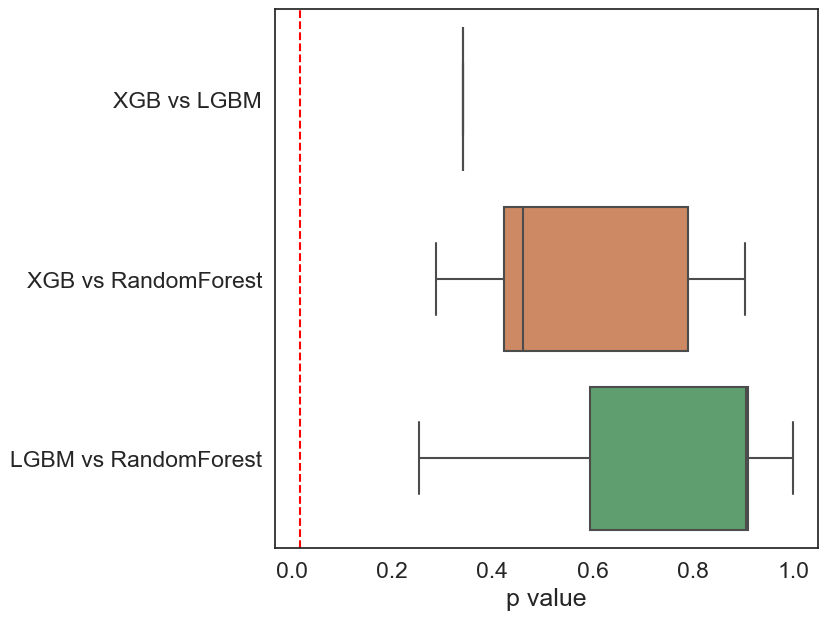

In [61]:
# Generate box plot using the p-value for the McNemar coefficient for each pair-wise comparison
ax = sns.boxplot(x="p-value",y="Combo",data=mcnemar_df)
ax.set(ylabel="",xlabel="p value")
#alpha is the signiifcant p-value
_ = ax.axvline(alpha,c="red",ls="--")

# Results show that the models accuarcy is not significantly different

In [65]:
auc_ci_df.head()

,Cycle,Classifier,AUC,LB,UB
0,0,XGB,0.92,0.90,0.93
1,0,LGBM,0.91,0.90,0.93
2,0,RandomForest,0.91,0.89,0.93
3,1,XGB,0.92,0.90,0.93
4,1,LGBM,0.91,0.90,0.93


#### 6. Friedman's Test with Mann-Whitney Post-hoc

Using scipy and scikit_posthocs

We can't do ANOVA because our samples are not independent

FriedmanchisquareResult(statistic=5.6000000000000085, pvalue=0.06081006262521769)


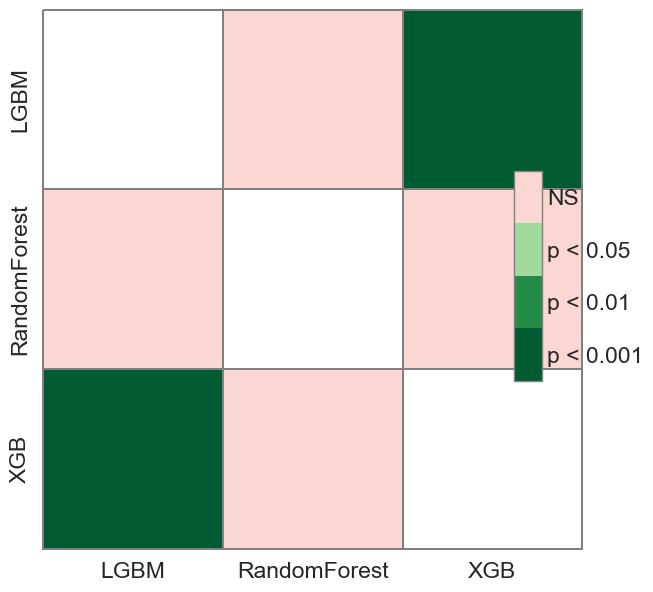

In [66]:
auc_dict = {}
for k,v in auc_ci_df.groupby("Classifier"):
    auc_dict[k] = v.AUC
print(stats.friedmanchisquare(*auc_dict.values()))

pc = sp.posthoc_mannwhitney(auc_ci_df,val_col="AUC",group_col="Classifier",p_adjust='holm')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
_ = sp.sign_plot(pc, **heatmap_args)

In [67]:
pc

,LGBM,RandomForest,XGB
LGBM,1.00e+00,0.89,4.78e-05
RandomForest,8.86e-01,1.00,8.86e-01
XGB,4.78e-05,0.89,1.00e+00
